# https://github.com/ksatola/Medical-Appointments-No-Shows/blob/master/no-shows-ks4-final.ipynb

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [41]:
df = pd.read_csv('./data/KaggleV2-May-2016/KaggleV2-May-2016.csv')

# Learn the size of the dataset
df.shape

(110527, 14)

In [42]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [43]:
# Typos in the column names as well as their format should be corrected / unified
df.columns = ['patient_id', 'appointment_id', 'gender', 'scheduled_day', 
              'appointment_day', 'age', 'neighbourhood', 'scholarship', 'hypertension',
              'diabetes', 'alcoholism', 'handicap', 'sms_received', 'no_show']
df.columns

Index(['patient_id', 'appointment_id', 'gender', 'scheduled_day',
       'appointment_day', 'age', 'neighbourhood', 'scholarship',
       'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received',
       'no_show'],
      dtype='object')

In [44]:
df.head(5)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110527 non-null float64
appointment_id     110527 non-null int64
gender             110527 non-null object
scheduled_day      110527 non-null object
appointment_day    110527 non-null object
age                110527 non-null int64
neighbourhood      110527 non-null object
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


## Here are some initial observations:
* There are 13 independent variables and one dependent (no_show) in the dataset.
* The dataset does not contain any missing values (NaNs).
* The patient_id data type is float but should be int.
* The scheduled_day and appointment_day columns type should be changed to datetime.
* The appointment_day has no hour specified (it equals to 00:00:00). We will not be able to analyze if the appointment hour has anything to do with no shows.
* There could be interesting to know how much time passed between a visit scheduling time and the actual visit time. There is no such data column but this can be calculated from scheduled_day and appointment_day columns.
* Another interesting question would be how show and no-show appointments are distributed among days of week. To explore this I will calculate a column called appointment_dow.


### Observation 3: The patient_id data type is float but should be int

In [46]:
# Check how many patients_ids are not integers
non_int_patient_ids = df[~ df.patient_id.apply(lambda x: x.is_integer())]
print('There are {} patients_ids that are not integers'.format(len(non_int_patient_ids)))
non_int_patient_ids

There are 5 patients_ids that are not integers


,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
3950,93779.52927,5712759,F,2016-05-18T09:12:29Z,2016-05-18T00:00:00Z,33,CENTRO,0,0,0,0,0,0,No
73228,537615.28476,5637728,F,2016-04-29T07:19:57Z,2016-05-06T00:00:00Z,14,FORTE SÃO JOÃO,0,0,0,0,0,1,No
73303,141724.16655,5637648,M,2016-04-29T07:13:36Z,2016-05-02T00:00:00Z,12,FORTE SÃO JOÃO,0,0,0,0,0,0,No
100517,39217.84439,5751990,F,2016-05-31T10:56:41Z,2016-06-03T00:00:00Z,44,PRAIA DO SUÁ,0,0,0,0,0,0,No
105430,43741.75652,5760144,M,2016-06-01T14:22:58Z,2016-06-01T00:00:00Z,39,MARIA ORTIZ,0,0,1,0,0,0,No


As there are only 5 float patient_ids, it seems they are typos. I will check if they would be unique ids when the decimal part is truncated. If yes, I will truncate their decimal part and keep them in the dataset.

In [47]:
patient_ids = non_int_patient_ids['patient_id'].astype('int64')

for id in patient_ids:
    if df.query('patient_id == {}'.format(id)).empty:
        print('Patient id == {} does not exist.'.format(id))
    else:
        print('Patient id == {} already exists.'.format(id))

Patient id == 93779 does not exist.
Patient id == 537615 does not exist.
Patient id == 141724 does not exist.
Patient id == 39217 does not exist.
Patient id == 43741 does not exist.


In [48]:
# Convert patient_id from float to int
df['patient_id'] = df['patient_id'].astype('int64')

# Check if the patient_id is int64
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110527 non-null int64
appointment_id     110527 non-null int64
gender             110527 non-null object
scheduled_day      110527 non-null object
appointment_day    110527 non-null object
age                110527 non-null int64
neighbourhood      110527 non-null object
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: int64(9), object(5)
memory usage: 11.8+ MB


### Observation 4: The scheduled_day and appointment_day columns type should be changed to datetime

In [49]:
# Convert columns types
df['scheduled_day'] = pd.to_datetime(df['scheduled_day']).dt.date.astype('datetime64[ns]')
df['appointment_day'] = pd.to_datetime(df['appointment_day']).dt.date.astype('datetime64[ns]')

# Check if the type is now datetime
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110527 non-null int64
appointment_id     110527 non-null int64
gender             110527 non-null object
scheduled_day      110527 non-null datetime64[ns]
appointment_day    110527 non-null datetime64[ns]
age                110527 non-null int64
neighbourhood      110527 non-null object
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: datetime64[ns](2), int64(9), object(3)
memory usage: 11.8+ MB


### Observation 6: Create a new column awaiting_time_days

In [50]:
# Create awaiting_time_days column
df['awaiting_time_days'] = (df.appointment_day - df.scheduled_day).dt.days # and convert timedelta to int

# Check if the column exists
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 15 columns):
patient_id            110527 non-null int64
appointment_id        110527 non-null int64
gender                110527 non-null object
scheduled_day         110527 non-null datetime64[ns]
appointment_day       110527 non-null datetime64[ns]
age                   110527 non-null int64
neighbourhood         110527 non-null object
scholarship           110527 non-null int64
hypertension          110527 non-null int64
diabetes              110527 non-null int64
alcoholism            110527 non-null int64
handicap              110527 non-null int64
sms_received          110527 non-null int64
no_show               110527 non-null object
awaiting_time_days    110527 non-null int64
dtypes: datetime64[ns](2), int64(10), object(3)
memory usage: 12.6+ MB


### Observation 7: Create a new column appointment_dow (day of week appointment)

In [51]:
# Create appointment_dow column
df['appointment_dow'] = df.scheduled_day.dt.weekday_name

# Check the values
df['appointment_dow'].value_counts()

Tuesday      26168
Wednesday    24262
Monday       23085
Friday       18915
Thursday     18073
Saturday        24
Name: appointment_dow, dtype: int64

In [52]:
df.describe()

,patient_id,appointment_id,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,awaiting_time_days
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,10.183702
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,15.254996
min,3.921700e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000


### Additional observations
* _age_: The patients are 37 years on average. 25% of patients are below 18 and most of them are below 55. There is a data range problem in the dataset. The age value cannot be below 0, and there are some very old people as well. To be investigated.
* handicap: is represented by 4 classes as opposed to other categorical variables in this dataset. This can be a result of an error or there are 4 categories used. Both options are potentially valid and this should be confirmed by an SME.
* sms_received: 75% of patients received sms regarding an appointment.
* awaiting_time_days: 10 days on average patients waited for an appointment. 50% of patients waited up to 4 days and 75% up to 15 days for an appointment. The longest awaiting time was 179 days. There is at least one case where a visit happened 6 days before it was scheduled. This should not happen and will be further investigated.

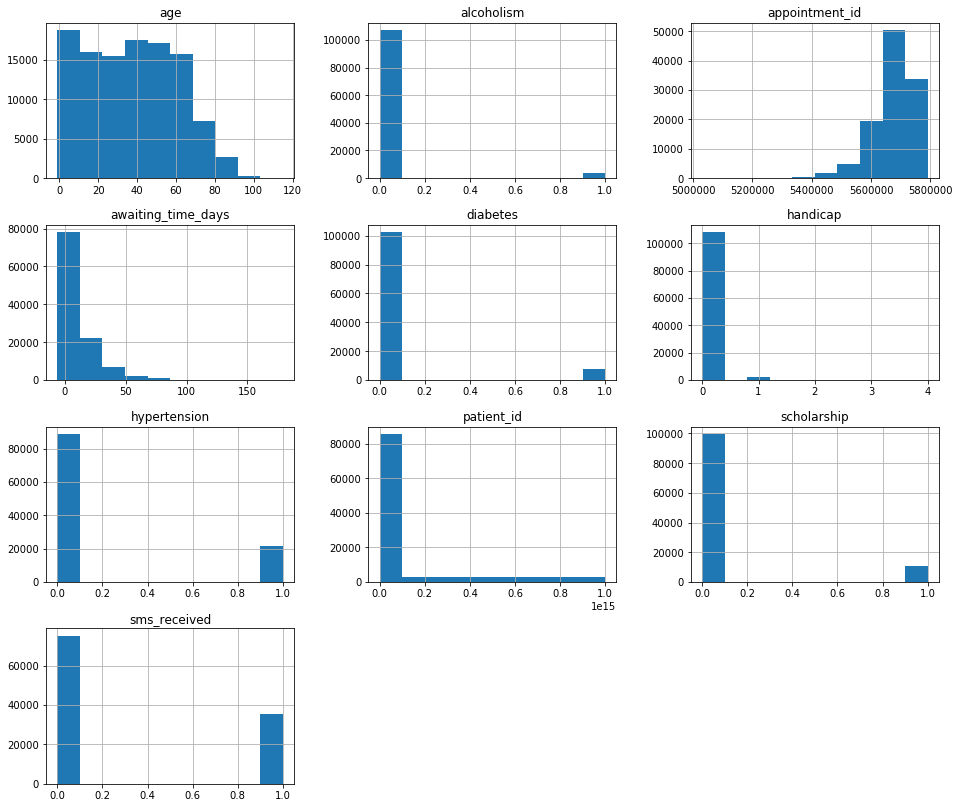

In [53]:
df.hist(figsize=(16,14));

## Histogram observations
* age: There are many very young people in the dataset but in general the patients age is distributed evenly and the number of patients goes drastricly down for patients older than 60 years.
* alcoholism: Most of the patients are not alcoholics.
* diabetes: Most of the patients are not diabetes but more than alcoholics.
* handicap: There are four handicap categories with most of the people not being handicapted.
* hypertension: Most patients do not have hypertension diagnosed.

In [54]:
# Gender
# Print Unique Values
print("Unique Values in `gender` => {}".format(df.gender.unique()))

Unique Values in `gender` => ['F' 'M']


In [55]:
# scheduled_day
# Print Unique Values
print("Unique Values in `scheduled_day` => {}".format(df.scheduled_day.unique()))

Unique Values in `scheduled_day` => ['2016-04-29T00:00:00.000000000' '2016-04-27T00:00:00.000000000'
 '2016-04-26T00:00:00.000000000' '2016-04-28T00:00:00.000000000'
 '2016-04-25T00:00:00.000000000' '2016-04-20T00:00:00.000000000'
 '2016-03-31T00:00:00.000000000' '2016-04-19T00:00:00.000000000'
 '2016-04-06T00:00:00.000000000' '2016-04-18T00:00:00.000000000'
 '2016-04-11T00:00:00.000000000' '2016-04-12T00:00:00.000000000'
 '2016-04-15T00:00:00.000000000' '2016-04-01T00:00:00.000000000'
 '2016-04-05T00:00:00.000000000' '2016-04-08T00:00:00.000000000'
 '2016-04-14T00:00:00.000000000' '2016-04-13T00:00:00.000000000'
 '2016-04-07T00:00:00.000000000' '2016-03-17T00:00:00.000000000'
 '2016-03-30T00:00:00.000000000' '2016-03-29T00:00:00.000000000'
 '2016-03-18T00:00:00.000000000' '2016-03-28T00:00:00.000000000'
 '2016-03-04T00:00:00.000000000' '2016-03-15T00:00:00.000000000'
 '2016-03-14T00:00:00.000000000' '2016-03-21T00:00:00.000000000'
 '2016-03-23T00:00:00.000000000' '2016-03-22T00:00:00.

In [56]:
# appointment_day

# Print Unique Values
print("Unique Values in `appointment_day` => {}".format(df.appointment_day.unique()))

Unique Values in `appointment_day` => ['2016-04-29T00:00:00.000000000' '2016-05-03T00:00:00.000000000'
 '2016-05-10T00:00:00.000000000' '2016-05-17T00:00:00.000000000'
 '2016-05-24T00:00:00.000000000' '2016-05-31T00:00:00.000000000'
 '2016-05-02T00:00:00.000000000' '2016-05-30T00:00:00.000000000'
 '2016-05-16T00:00:00.000000000' '2016-05-04T00:00:00.000000000'
 '2016-05-19T00:00:00.000000000' '2016-05-12T00:00:00.000000000'
 '2016-05-06T00:00:00.000000000' '2016-05-20T00:00:00.000000000'
 '2016-05-05T00:00:00.000000000' '2016-05-13T00:00:00.000000000'
 '2016-05-09T00:00:00.000000000' '2016-05-25T00:00:00.000000000'
 '2016-05-11T00:00:00.000000000' '2016-05-18T00:00:00.000000000'
 '2016-05-14T00:00:00.000000000' '2016-06-02T00:00:00.000000000'
 '2016-06-03T00:00:00.000000000' '2016-06-06T00:00:00.000000000'
 '2016-06-07T00:00:00.000000000' '2016-06-01T00:00:00.000000000'
 '2016-06-08T00:00:00.000000000']


In [57]:
# Print Unique Values
print("Unique Values in `age` => {}".format(sorted(df.age.unique())))

Unique Values in `age` => [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]


Age value cannot be less than 0. I will remove all records with such values. I have also concerns with age values greater than 100 although they happen sometimes ( see: https://en.wikipedia.org/wiki/Oldest_people ). I will remove all records with age greater than 110 as they are unlikely to happen in such small dataset.

In [58]:
print('Before change')
print("Patients with `Age` less than -1 -> {}".format(df[df.age == -1].shape[0]))
print("Patients with `Age` equal to 0 -> {}".format(df[df.age == 0].shape[0]))
print("Patients with `Age` greater than 110 -> {}".format(df[df.age > 110].shape[0]))

df = df[(df.age >= 0) & (df.age <= 110)]
df.age.value_counts()

print('After change')
print("Patients with `Age` less than -1 -> {}".format(df[df.age == -1].shape[0]))
print("Patients with `Age` equal to 0 -> {}".format(df[df.age == 0].shape[0]))
print("Patients with `Age` greater than 110 -> {}".format(df[df.age > 110].shape[0]))

Before change
Patients with `Age` less than -1 -> 1
Patients with `Age` equal to 0 -> 3539
Patients with `Age` greater than 110 -> 5
After change
Patients with `Age` less than -1 -> 0
Patients with `Age` equal to 0 -> 3539
Patients with `Age` greater than 110 -> 0


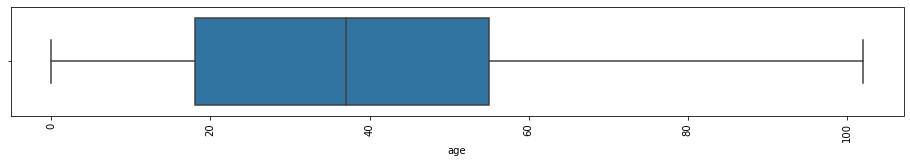

In [59]:
# Let's see a boxplot showing what is age values distribution (already seen above in a histogram and basic descriptive statistics table)
plt.figure(figsize=(16,2))
plt.xticks(rotation=90)
_ = sns.boxplot(x=df.age)

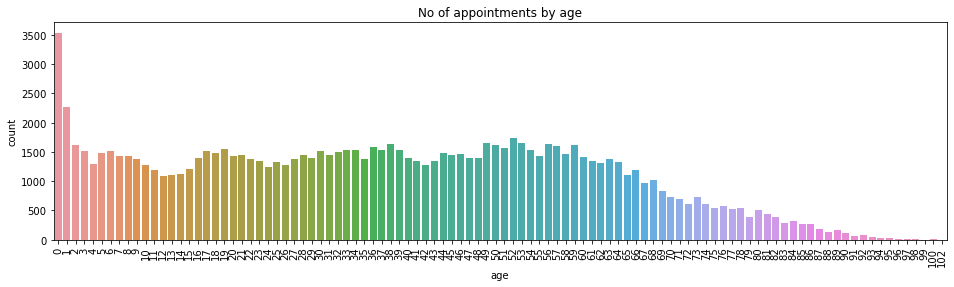

In [60]:
# Let's see how many there are patients of each age
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.age)
ax.set_title("No of appointments by age")
plt.show()

The above histogram shows a peak for the infants (patients of age 0). For higher age values the distribution starts to be uniform. After the age value of around 60 we see a right-skewed distribution.

In [61]:
# Print Unique Values
print("Unique Values in `scholarship` => {}".format(df.scholarship.unique()))

Unique Values in `scholarship` => [0 1]


In [62]:
# Print Unique Values
print("Unique Values in `hypertension` => {}".format(df.hypertension.unique()))

Unique Values in `hypertension` => [1 0]


In [63]:
# Print Unique Values
print("Unique Values in `diabetes` => {}".format(df.diabetes.unique()))

Unique Values in `diabetes` => [0 1]


In [64]:
# Print Unique Values
print("Unique Values in `alcoholism` => {}".format(df.alcoholism.unique()))

Unique Values in `alcoholism` => [0 1]


In [65]:
# Print Unique Values
print("Unique Values in `handicap` => {}".format(df.handicap.unique()))

Unique Values in `handicap` => [0 1 2 3 4]


In [66]:
# The handicap column contains 4 numeric values (classes), which is unusual comparing to other cathegorical variables in the dataset
df.handicap.value_counts()

0    108284
1      2038
2       183
3        13
4         3
Name: handicap, dtype: int64

In [67]:
# Print Unique Values
print("Unique Values in `sms_received` => {}".format(df.sms_received.unique()))

Unique Values in `sms_received` => [0 1]


In [68]:
# Print Unique Values
print("Unique Values in `awaiting_time_days` => {}".format(df.awaiting_time_days.unique()))

Unique Values in `awaiting_time_days` => [  0   2   3   1   4   9  29  10  23  11  18  17  14  28  24  21  15  16
  22  43  30  31  42  32  56  45  46  39  37  38  44  50  60  52  53  65
  67  91  66  84  78  87 115 109  63  70  72  57  58  51  59  41  49  73
  64  20  33  34   6  35  36  12  13  40  47   8   5   7  25  26  48  27
  19  61  55  62 176  54  77  69  83  76  89  81 103  79  68  75  85 112
  -1  80  86  98  94 142 155 162 169 104 133 125  96  88  90 151 126 127
 111 119  74  71  82 108 110 102 122 101 105  92  97  93 107  95  -6 139
 132 179 117 146 123]


In [69]:
# Awaiting time cannot be less than 0. I am assuming that a visit cannot happen before it is scheduled.
# Let's see how many such values exist
print('Before change: {}'.format(df[(df.awaiting_time_days < 0)].awaiting_time_days.value_counts()))

# I will remove all records with such values.
df = df[(df.awaiting_time_days >= 0)]

#Check if any awaiting time days values below 0 left in the dataset
print('After change: {}'.format(df[(df.awaiting_time_days < 0)].awaiting_time_days.value_counts()))

Before change: -1    4
-6    1
Name: awaiting_time_days, dtype: int64
After change: Series([], Name: awaiting_time_days, dtype: int64)


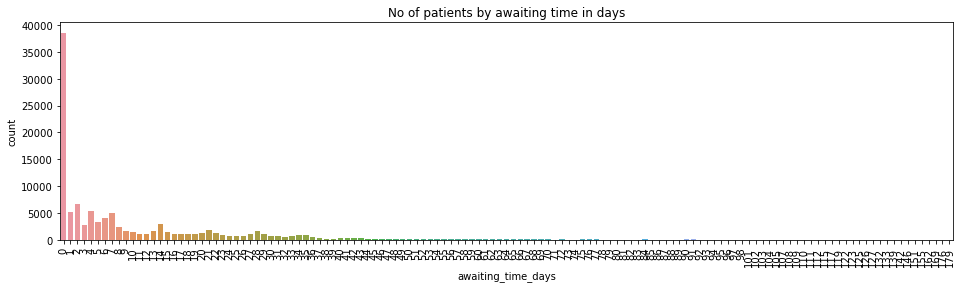

In [70]:
# Let's see how many there are patients of each age
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.awaiting_time_days)
ax.set_title("No of patients by awaiting time in days")
plt.show()

In [71]:
# Return number of patients with awaiting_time_days == 0
awaiting0 = df[(df.awaiting_time_days == 0)].awaiting_time_days.value_counts()
awaiting0

0    38561
Name: awaiting_time_days, dtype: int64

It is worth to notice that almost 40k patients scheduled their visit for the same day.

In [72]:
awaiting0_not_showed_up = len(df.query('awaiting_time_days  == 0 and no_show == "Yes"'))
awaiting0_not_showed_up_ratio = int(round(awaiting0_not_showed_up/awaiting0[0]*100))
print('Out of all patients scheduling an appointment for the same day (in total {}), {} of patients did not show up ({}%).'.format(awaiting0[0], 
                                                                                                                                   awaiting0_not_showed_up, 
                                                                                                                                   awaiting0_not_showed_up_ratio))

Out of all patients scheduling an appointment for the same day (in total 38561), 1792 of patients did not show up (5%).


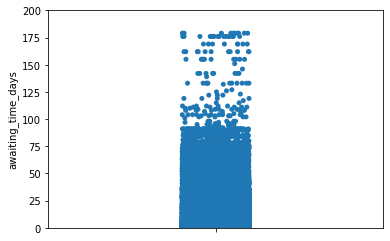

In [73]:
# It seems that most of the visits happened within 3 months from being scheduled
sns.stripplot(data = df, y = 'awaiting_time_days', jitter = True)
plt.ylim(0, 200)
plt.show();

Scheduling visits started on: 2015-11-10 00:00:00.
Scheduling visits ended on: 2016-06-08 00:00:00.


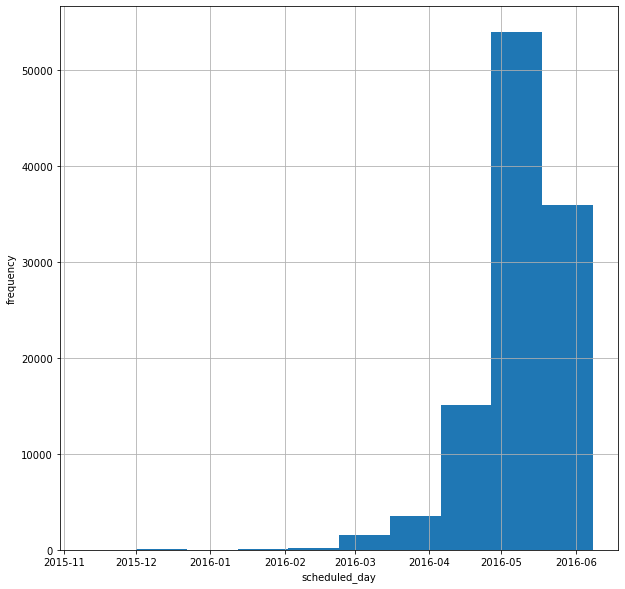

In [74]:
print('Scheduling visits started on: {}.'.format(df['scheduled_day'].min()))
print('Scheduling visits ended on: {}.'.format(df['scheduled_day'].max()))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('scheduled_day')
ax.set_ylabel('frequency')
df['scheduled_day'].hist();

Visit appointments started on: 2016-04-29 00:00:00.
Visit appointments ended on: 2016-06-08 00:00:00.


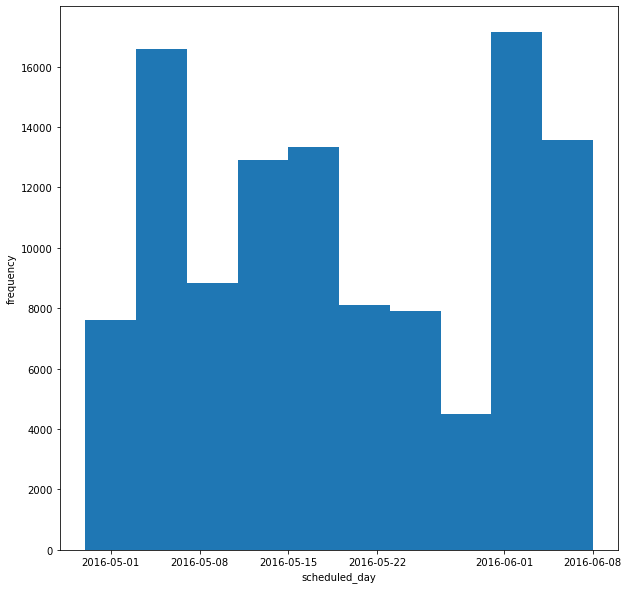

In [75]:
print('Visit appointments started on: {}.'.format(df['appointment_day'].min()))
print('Visit appointments ended on: {}.'.format(df['appointment_day'].max()))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('scheduled_day')
ax.set_ylabel('frequency')
df['appointment_day'].hist(grid=False, ax=ax);

In [76]:
df.appointment_dow.value_counts()

Tuesday      26167
Wednesday    24259
Monday       23081
Friday       18914
Thursday     18071
Saturday        24
Name: appointment_dow, dtype: int64

## Questions
Based on dataset analysis, I will focus on putting more light on answers to the following questions:

* How many percent of patients missed their scheduled appointment?
* What is the gender distribution for show / no-show patients?
* Are there patients with more than one appointment? If yes, what are the top 10 patients with most appointments?
* What factors are important to know in order to predict if a patient will show up for their scheduled appointment?
* What is age distribution of diabetes who showed and did not show up?
* How activities done by an appointment scheduling office (sending SMS, participation in scholarship) influence show / no-show ratio?


20% of appointments missed.


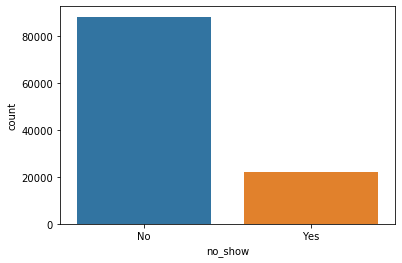

In [82]:
sns.countplot(x=df.no_show);

missed_ratio = round(len(df.query('no_show == \'Yes\''))/df.shape[0] * 100)
print("{}% of appointments missed.".format(missed_ratio))

#### 2. What is the gender distribution for show / no-show patients?

In [155]:
gender_dist = df[['gender', 'no_show']].groupby(['gender', 'no_show'])['no_show'].count().unstack('no_show')
gender_dist['total'] = gender_dist['No'] + gender_dist['Yes']
gender_dist['absence_percent'] = round(gender_dist['Yes']/gender_dist['total'] * 100)

In [156]:
gender_dist

no_show,No,Yes,total,absence_percent
gender,,,,
F,57243,14588,71831,20.0
M,30962,7723,38685,20.0


In [159]:
f = gender_dist.query('gender == \'F\'')
m = gender_dist.query('gender == \'M\'')

print('Out of {} appointments made by females, {} were missed with the ratio of {}%.'.format(f['total'].item(), f['Yes'].item(), f['absence_percent'].item()))
print('Out of {} appointments made by males, {} were missed with the ratio of {}%.'.format(m['total'].item(), m['Yes'].item(), m['absence_percent'].item()))

Out of 71831 appointments made by females, 14588 were missed with the ratio of 20.0%.
Out of 38685 appointments made by males, 7723 were missed with the ratio of 20.0%.


### 3. Are there patients with more than one appointment? If yes, what are the top 10 patients with most appointments?

In [152]:
df.patient_id.value_counts().iloc[0:10]

822145925426128    88
99637671331        84
26886125921145     70
33534783483176     65
258424392677       62
75797461494159     62
871374938638855    62
6264198675331      62
66844879846766     57
872278549442       55
Name: patient_id, dtype: int64

There are patients with multiple appointments. The number of appointments of top 10 patients range from 88 to 55. Taking into consideration, that the time range of visits appointed spans over 1.5 months, an appointment is most likely each examination or each specialist visit. So within one patient visit in a hospital, there could be multiple appointments scheduled. One of the no-show reasons could be the fact, that patients could be too tired to take part in all examinations during a particular visit, or the open hours were not sufficient to show up in all appointments. There could be also other reasons. The high number of appointments over so short period of time should be consulted with an SME to decide if performing (or not) additional analysis in this area makes sense.

### 4. What factors are important to know in order to predict if a patient will show up for their scheduled appointment?

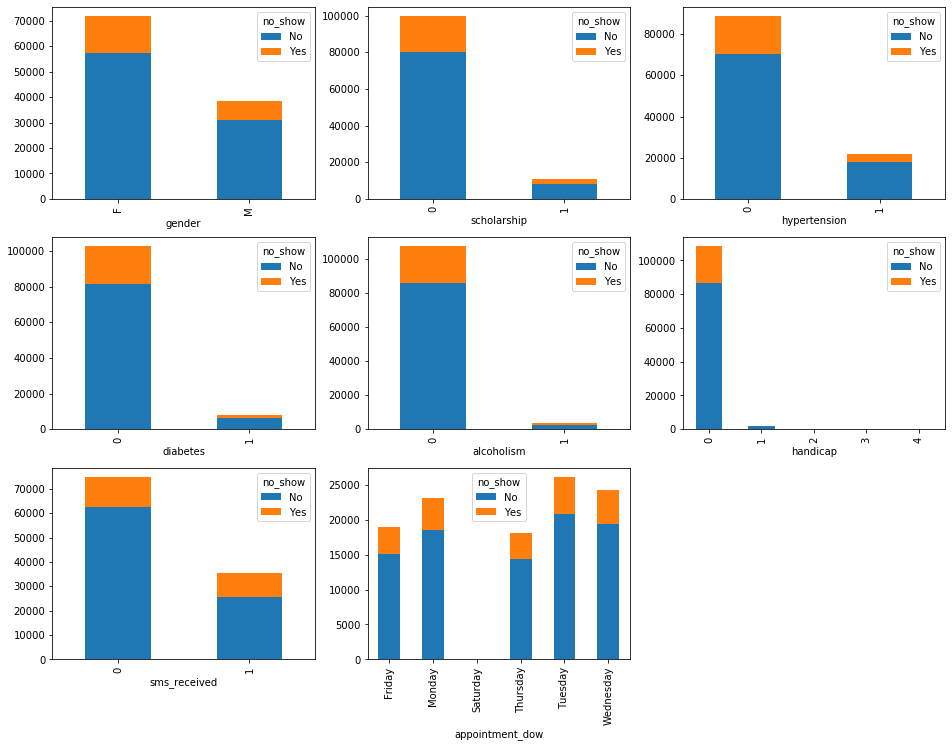

In [166]:
# First, let's look at categorical variables
categorical_vars = ['gender', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received', 'appointment_dow']

fig = plt.figure(figsize=(16, 12))
for i, var in enumerate(categorical_vars):
    ax = fig.add_subplot(3, 3, i+1)
    df.groupby([var, 'no_show'])[var].count().unstack('no_show').plot(ax=ax, kind='bar', stacked=True)

For all categorical variables the distributions of show / no-show for different categories look very similar. There is no clear indication of any of these variables having bigger then others impact on show / no-show characteristics. The charts confirm about 20% no-show rate for most categories.

In [169]:
# Two useful masks to be used in further analysis
showed = df.no_show == 'No'
not_showed = df.no_show == 'Yes'

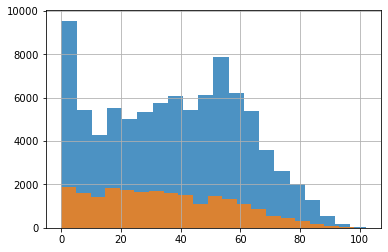

In [170]:
# Let's now look closer to numerical variables
# Age:
df.age[showed].hist(alpha=0.8, bins=20);
df.age[not_showed].hist(alpha=0.8, bins=20);

Infants show up most often then people around 50-55. But between 1-65 years old, the rate of no-shows seems to be higher than 20%.

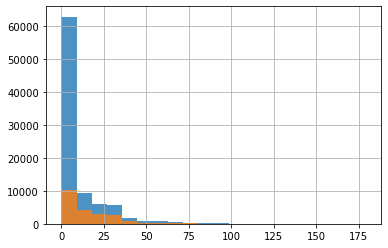

In [172]:
# Number of days between the date of scheduling an appointment and the appointment itself
df.awaiting_time_days[showed].hist(alpha=0.8, bins=20);
df.awaiting_time_days[not_showed].hist(alpha=0.8, bins=20);

The shorten awaiting period the more patients show up. Patiens scheduling appointments for the same day are much more likely to show up (ca. 17% of not showing up only).

### 5. What is age distribution of diabetes who showed and did not show up?

In [173]:
# This is a helper column representing no_shows in a numerical form (Yes->1, No->0)
df['no_show_numeric'] = np.where(df['no_show']=='Yes', 1, 0)

In [176]:
df[['diabetes', 'no_show_numeric']].groupby(['diabetes'], as_index=False).mean().sort_values(by='no_show_numeric', ascending=False)

,diabetes,no_show_numeric
0,0,0.203572
1,1,0.180033


In general, 18% of diabetes did not show up, which is about 2% lower from the general average of not showing up. It seems that diabetes are more careful about their health and take medial appointments more seriously then non diabetes.

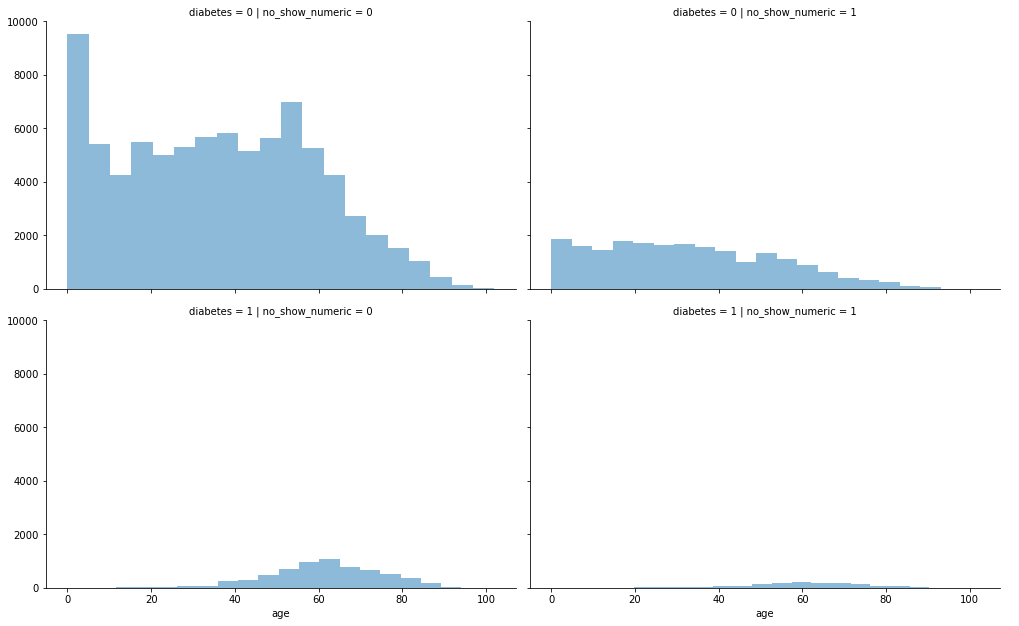

In [175]:
grid = sns.FacetGrid(df, col='no_show_numeric', row='diabetes', height=4.4, aspect=1.6)
grid.map(plt.hist, 'age', alpha=.5, bins=20)
grid.add_legend();

The diabetes distribution shape is symetrical. The mean of this distribution is about 60. To calculate it more precisely, as well as its standard deviation a statistical method should be used.